<a href="https://colab.research.google.com/github/Elisakova/github_welcom/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%B0%D1%8F__%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%98%D1%81%D0%B0%D0%BA%D0%BE%D0%B2%D0%B0_%D0%95_%D0%A1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание временных рядов

## Введение. Постановка целей и задач.

Изменения в солнечной активности   связывают с изменением климата,  влияние на  здоровье человека . Ученые видят зависимость количества  пятен на солнце с уровнем солнечной активности , например, в период уменьшения количества наблюдалось похолодание климата. 
Цень данной работы создать модель для  прогноза количества пятен на солнце. 

### Импорт Датафрейма, библиотек, написание функций.

В этом блоке мы импортируем все, что нам нужно для работы: библиотеки, отдельные функции, сам датасет.

In [29]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima 


In [31]:
import statsmodels.api as sm
data = sm.datasets.sunspots.load_pandas()

In [237]:
df=data.data

df.tail()

,YEAR,SUNACTIVITY,DATE
2004-12-31,2004,40.4,2004-01-01
2005-12-31,2005,29.8,2005-01-01
2006-12-31,2006,15.2,2006-01-01
2007-12-31,2007,7.5,2007-01-01
2008-12-31,2008,2.9,2008-01-01


Знакомство с данными.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 1700-12-31 to 2008-12-31
Freq: A-DEC
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SUNACTIVITY  309 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


In [ ]:
df.dtypes

YEAR           float64
SUNACTIVITY    float64
dtype: object

In [ ]:
df.shape

(309, 2)

In [ ]:
df.isnull().sum()

YEAR           0
SUNACTIVITY    0
dtype: int64

Выводы по разделу: Датасет  содержит 309  наблюдений, две  переменные , тип переменной -float , переменная  YEAR -  год  наблюжени, SUNACTIVITY -  количество  пятен на солнце.  SUNACTIVITY - целевая переменная . В данных  нет пропущених значений. 



## Предобработка данных

In [238]:
import datetime
df['YEAR'] = df['YEAR'].astype('int')
df['DATE'] = df['YEAR'].map(lambda x: datetime.date(x, 1, 1))
df.head()


,YEAR,SUNACTIVITY,DATE
1700-12-31,1700,5.0,1700-01-01
1701-12-31,1701,11.0,1701-01-01
1702-12-31,1702,16.0,1702-01-01
1703-12-31,1703,23.0,1703-01-01
1704-12-31,1704,36.0,1704-01-01


In [239]:
df.index=pd.Index(pd.date_range("1700", end="2009", freq="A-DEC"))
df.head()

,YEAR,SUNACTIVITY,DATE
1700-12-31,1700,5.0,1700-01-01
1701-12-31,1701,11.0,1701-01-01
1702-12-31,1702,16.0,1702-01-01
1703-12-31,1703,23.0,1703-01-01
1704-12-31,1704,36.0,1704-01-01


### Вывод по этапу. Т.к. датасете не  было пропущенных  данных,  дублирующих  значений и  данных  типа object или str не применялись методы обработки данных. Нормализация данных  включала  только  подготовку атрибута дата для анализа сезонной состовляющей 


## EDA или разведочный анализ данных.

In [240]:
df.describe()

,YEAR,SUNACTIVITY
count,309.000000,309.000000
mean,1854.000000,49.752104
std,89.344838,40.452595
min,1700.000000,0.000000
25%,1777.000000,16.000000
50%,1854.000000,40.000000
75%,1931.000000,69.800000
max,2008.000000,190.200000


In [36]:
import plotly.express as px
fig=px.line(df, x='YEAR', y='SUNACTIVITY', title="Количество солнечных  пятен по годам" )
fig.show()


ETS декомпозиция

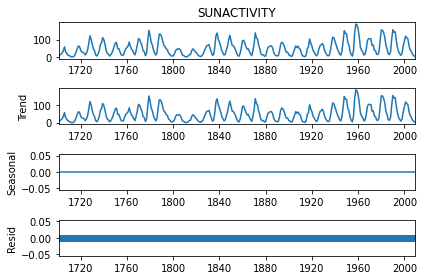

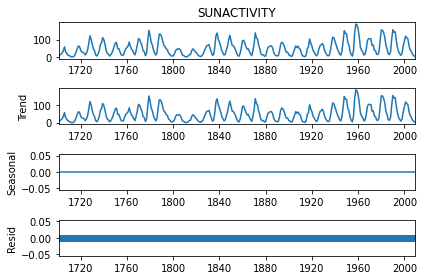

In [37]:
decomposition=sm.tsa.seasonal_decompose(df['SUNACTIVITY'], model='additive')
result=seasonal_decompose(df['SUNACTIVITY'], model='add')
result.plot()

**Построение моделей, анализ результатов.**

Модель ARIMA.

Наиболее популярная модель для прогноза временных рядов -ARIMA 
Описание  модели :ARIMA описывает корреляцию между точками данных и учитывает разницу значений.
ARIMA использует три основных параметра (p, d, q).Эти три параметра учитывают сезонность, тенденцию и шум в наборах данных.
AR (авторегрессия)-p, I (разность) -d и MA (скользящая средняя)-q.
При построении модели будем использовать Auto ARIMA для  определения значения p и q. 

1.Делим данные на обучающую и проверочную выборки

In [241]:
train_arima= df.iloc[:-15]
test_arima=df.iloc[-15:]  
train_arima.shape



(294, 3)

строим график наших данных

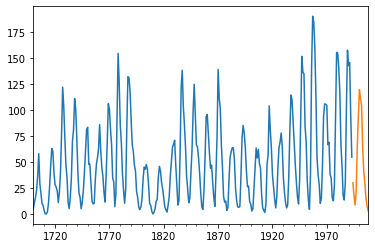

In [242]:
train_arima['SUNACTIVITY'].plot()
test_arima['SUNACTIVITY'].plot()

2.Строим модель

2.1. Расчет гиперпараметров (p,d,q)

In [243]:

from pmdarima.arima.auto import AutoARIMA
auto_arima(df['SUNACTIVITY'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  309
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1280.477
Date:                Sun, 05 Feb 2023   AIC                           2572.954
Time:                        16:43:23   BIC                           2595.335
Sample:                    12-31-1700   HQIC                          2581.903
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6145      0.026     62.096      0.000       1.564       1.665
ar.L2         -0.9354      0.022    -41.820      0.000      -0.979      -0.892
ma.L1         -1.4392      0.059    -24.590      0.000      -1.554      -1.324
ma.L2          0.4545      0.095      4.783      0.000       0.268       0.641
ma.L3          0.1285      0.060      2.143      0.032       0.011       0.246
sigma2       236.7573     16.333     14.495      0.000     204.744     268.770
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                43.72
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.54
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

	SARIMAX(2, 1, 3)	- гиперпараметры 

3.Создаем и обучаем модель 

In [244]:
model_arima=SARIMAX(train['SUNACTIVITY'], order=(2,1,3)).fit()
model_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  294
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1221.343
Date:                Sun, 05 Feb 2023   AIC                           2454.687
Time:                        16:43:56   BIC                           2476.768
Sample:                    12-31-1700   HQIC                          2463.530
                         - 12-31-1993                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6061      0.028     57.845      0.000       1.552       1.661
ar.L2         -0.9304      0.023    -39.601      0.000      -0.976      -0.884
ma.L1         -1.4290      0.060    -23.660      0.000      -1.547      -1.311
ma.L2          0.4439      0.097      4.556      0.000       0.253       0.635
ma.L3          0.1254      0.063      1.998      0.046       0.002       0.248
sigma2       241.9604     17.176     14.087      0.000     208.297     275.624
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                38.04
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.53
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

4.Делаем прогноз

In [246]:
fcast_arima = model_arima.forecast(15)
fcast_arima

1994-12-31     29.307723
1995-12-31     21.009065
1996-12-31     31.010730
1997-12-31     54.796233
1998-12-31     83.693245
1999-12-31    107.975074
2000-12-31    120.088311
2001-12-31    116.951177
2002-12-31    100.641873
2003-12-31     77.365691
2004-12-31     55.155586
2005-12-31     41.140002
2006-12-31     39.294082
2007-12-31     49.369900
2008-12-31     67.270628
Freq: A-DEC, Name: predicted_mean, dtype: float64

5.Сравниваем предсказание с данными обучающей выборки 

In [247]:
for i in range(len(fcast_arima)):
  print(f"predicted={fcast_arima[i]:<11.10}, expected={test_arima['SUNACTIVITY'][i]}")

predicted=29.30772315, expected=29.9
predicted=21.00906473, expected=17.5
predicted=31.01073035, expected=8.6
predicted=54.79623266, expected=21.5
predicted=83.69324525, expected=64.3
predicted=107.9750744, expected=93.3
predicted=120.0883108, expected=119.6
predicted=116.9511771, expected=111.0
predicted=100.6418734, expected=104.0
predicted=77.36569112, expected=63.7
predicted=55.15558595, expected=40.4
predicted=41.14000245, expected=29.8
predicted=39.29408226, expected=15.2
predicted=49.36989976, expected=7.5
predicted=67.27062796, expected=2.9


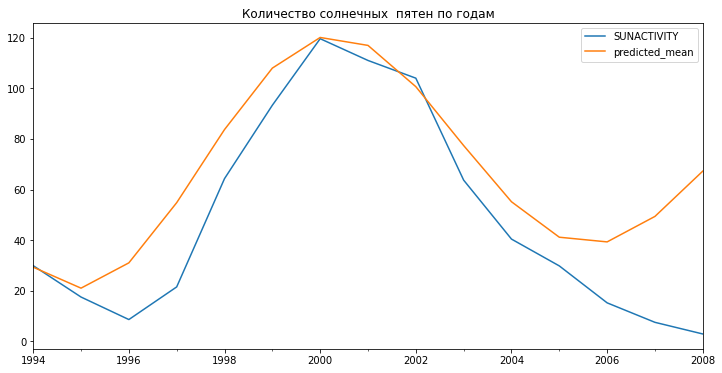

In [248]:
xtitle="Количество солнечных  пятен по годам"

ax=test_arima['SUNACTIVITY'].plot(legend=True, figsize=(12,6), title=xtitle)
fcast_arima.plot(legend=True)
ax.autoscale(axis='x', tight=True)


6.Рассчитываем качество полученной модели и прогноза



In [249]:
from sklearn.metrics import mean_squared_error
error_mse=mean_squared_error(test_arima['SUNACTIVITY'], fcast_arima)
print(f"SARIMAX(2, 1, 3) MSE error:{error_mse}")


SARIMAX(2, 1, 3) MSE error:618.1464764830586


In [250]:
from statsmodels.tools.eval_measures import rmse
error_rmse=rmse(test_arima['SUNACTIVITY'], fcast_arima)
print(f"SARIMAX(2, 1, 3)	RMSE error:{error_rmse}")

SARIMAX(2, 1, 3)	RMSE error:24.86255168889667


In [251]:
from sklearn.metrics import mean_absolute_error

print("SARIMAX(2, 1, 3) Mean Absolute Error (MAE):", mean_absolute_error(test_arima['SUNACTIVITY'], fcast_arima)) 

SARIMAX(2, 1, 3) Mean Absolute Error (MAE): 18.251341886514407


6.Применяем модель  ко всей выборке и сторим прогноз

In [340]:
model_full_arima=SARIMAX(df['SUNACTIVITY'], order=(2,1,3))
result=model_full_arima.fit()

fcast_full_arima=result.predict(len(df), len(df)+15, typ='levels' ).rename( 'predicrion SARIMAX(2, 1, 3)	')
fcast_full_arima

309    25.823885
310    55.697823
311    79.746206
312    90.630207
313    85.708851
314    67.582655
315    42.920522
316    20.057197
317     6.211590
318     5.242866
319    16.629494
320    35.919719
321    56.413844
322    71.458982
323    76.580448
324    70.776576
Name: predicrion SARIMAX(2, 1, 3)\t, dtype: float64

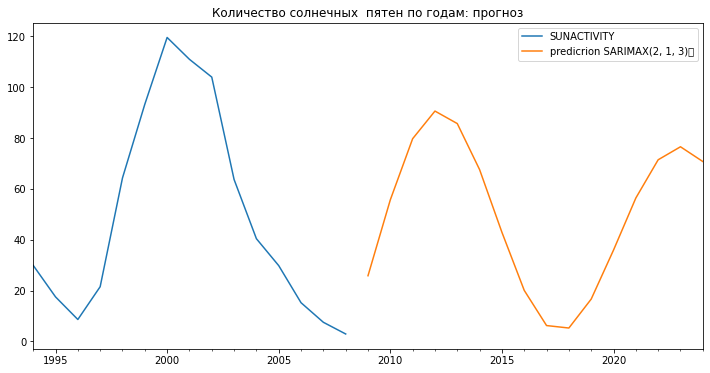

In [256]:
xtitle="Количество солнечных  пятен по годам: прогноз"

ax=test_arima['SUNACTIVITY'].plot(legend=True, figsize=(12,6), title=xtitle)
fcast_full_arima.plot(legend=True)
ax.autoscale(axis='x', tight=True)


**Модель Prophet**

в основе этой методологии лежит процедура подгонки аддитивных регрессионных моделей. Временной ряд  = Тренд + Сезонность + Праздник + Ошибка

Импорт библиотек 

In [129]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 KB 3.2 MB/s eta 0:00:00
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [338]:
from prophet import Prophet

In [304]:
import statsmodels.api as sm
data = sm.datasets.sunspots.load_pandas()
df=data.data.copy()
df

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


Создать входные данные  Prophet - фрейм данных: ds и y.

ds - столбец с датой
y - числовой столбец, который мы хотим  спрогнозировать

In [306]:
df['YEAR'] = df['YEAR'].astype('int')
df['DATE'] = df['YEAR'].map(lambda x: datetime.date(x, 1, 1))
df.tail()

,YEAR,SUNACTIVITY,DATE
304,2004,40.4,2004-01-01
305,2005,29.8,2005-01-01
306,2006,15.2,2006-01-01
307,2007,7.5,2007-01-01
308,2008,2.9,2008-01-01


In [310]:
df_prophet = df[['DATE', 'SUNACTIVITY']]
df_prophet.columns = ['ds', 'y']
df_prophet




,ds,y
0,1700-01-01,5.0
1,1701-01-01,11.0
2,1702-01-01,16.0
3,1703-01-01,23.0
4,1704-01-01,36.0
...,...,...
304,2004-01-01,40.4
305,2005-01-01,29.8
306,2006-01-01,15.2
307,2007-01-01,7.5


In [311]:
#df_prophet.to_csv('SUNACTIVITY.csv')

1.Делим данные на обучающую и проверочную выборки

In [312]:
train_df_prophet = df_prophet[:-30]
train_df_prophet


,ds,y
0,1700-01-01,5.0
1,1701-01-01,11.0
2,1702-01-01,16.0
3,1703-01-01,23.0
4,1704-01-01,36.0
...,...,...
274,1974-01-01,34.5
275,1975-01-01,15.5
276,1976-01-01,12.6
277,1977-01-01,27.5


2. Строим и обучаем модель 

аддитивная модель: прогноз = тренд + сезонности + праздники

In [313]:
model_prophet = Prophet(seasonality_mode='additive',
                  yearly_seasonality = False,
                  weekly_seasonality = False,
                  daily_seasonality = False,
                  ).add_seasonality(name='custom_seasonality',
                                    period=150,
                                    fourier_order = 15)
                  
model_prophet.fit(train_df_prophet)                

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bf_fne2/m5y66a2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bf_fne2/ov8qb7jx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87668', 'data', 'file=/tmp/tmp4bf_fne2/m5y66a2g.json', 'init=/tmp/tmp4bf_fne2/ov8qb7jx.json', 'output', 'file=/tmp/tmp4bf_fne2/prophet_modelv1yih0s3/prophet_model-20230205172428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [314]:
train_df_prophet.tail()

,ds,y
274,1974-01-01,34.5
275,1975-01-01,15.5
276,1976-01-01,12.6
277,1977-01-01,27.5
278,1978-01-01,92.5


In [315]:
future_df = model_prophet.make_future_dataframe(periods=14, freq='Y')
future_df

,ds
0,1700-01-01
1,1701-01-01
2,1702-01-01
3,1703-01-01
4,1704-01-01
...,...
288,1987-12-31
289,1988-12-31
290,1989-12-31
291,1990-12-31


3.Делаем прогноз 

In [316]:
fcast_prophet = model_prophet.predict(future_df)
fcast_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,custom_seasonality,custom_seasonality_lower,custom_seasonality_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1700-01-01,34.652538,-5.219778,76.517369,34.652538,34.652538,0.148686,0.148686,0.148686,0.148686,0.148686,0.148686,0.0,0.0,0.0,34.801224
1,1701-01-01,34.746206,1.209998,87.469784,34.746206,34.746206,9.311596,9.311596,9.311596,9.311596,9.311596,9.311596,0.0,0.0,0.0,44.057802
2,1702-01-01,34.839875,0.910496,84.402363,34.839875,34.839875,10.467270,10.467270,10.467270,10.467270,10.467270,10.467270,0.0,0.0,0.0,45.307145
3,1703-01-01,34.933543,18.158744,97.733759,34.933543,34.933543,21.463767,21.463767,21.463767,21.463767,21.463767,21.463767,0.0,0.0,0.0,56.397310
4,1704-01-01,35.027212,15.374686,100.157609,35.027212,35.027212,23.538994,23.538994,23.538994,23.538994,23.538994,23.538994,0.0,0.0,0.0,58.566206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1987-12-31,60.920522,8.243011,93.902776,60.919521,60.921566,-9.071890,-9.071890,-9.071890,-9.071890,-9.071890,-9.071890,0.0,0.0,0.0,51.848632
289,1988-12-31,61.012128,-6.618613,78.477433,61.010954,61.013380,-26.128406,-26.128406,-26.128406,-26.128406,-26.128406,-26.128406,0.0,0.0,0.0,34.883722
290,1989-12-31,61.103483,-4.725671,85.062443,61.102111,61.104958,-19.801046,-19.801046,-19.801046,-19.801046,-19.801046,-19.801046,0.0,0.0,0.0,41.302438
291,1990-12-31,61.194839,2.705457,84.896191,61.193254,61.196546,-16.408022,-16.408022,-16.408022,-16.408022,-16.408022,-16.408022,0.0,0.0,0.0,44.786817


4.Сравниваем предсказания с данными обучающей выборки

In [320]:
df_pred = fcast_prophet[['ds', 'trend', 'custom_seasonality', 'yhat']].copy()
df_pred['ds'] = df_pred['ds'].astype('object')
df_pred['ds'] = pd.to_datetime(df_pred['ds']).dt.date

future_df['ds'] = future_df['ds'].astype('object')
future_df['ds'] = pd.to_datetime(future_df['ds']).dt.date

df_prophet['ds'] = df_prophet['ds'].astype('object')
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.date

df_pred = df_pred.merge(future_df, on ='ds').merge(df_prophet, on='ds', how='left')
df_pred.tail()

,ds,trend,custom_seasonality,yhat,y
288,1987-12-31,60.920522,-9.071890,51.848632,NaN
289,1988-12-31,61.012128,-26.128406,34.883722,NaN
290,1989-12-31,61.103483,-19.801046,41.302438,NaN
291,1990-12-31,61.194839,-16.408022,44.786817,NaN
292,1991-12-31,61.286194,-13.914263,47.371931,NaN


In [321]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_pred['ds'], y=df_pred['y'],
                    mode='lines+markers',
                    name='y'))
fig.add_trace(go.Scatter(x=df_pred['ds'], y=df_pred['yhat'],
                    mode='lines+markers',
                    name='yhat'))
fig.add_trace(go.Scatter(x=df_pred['ds'], y=df_pred['custom_seasonality'],
                    mode='lines',
                    name='custom_seasonality'))
fig.add_trace(go.Scatter(x=df_pred['ds'], y=df_pred['trend'],
                    mode='lines',
                    name='trend'))

fig.show()

5.Расчитываем качество полученной модели 

In [322]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [335]:
mae_error=mean_absolute_error(df_prophet, fcast_prophet )

ValueError: ignored

## Выводы

В ходе работы проанализированы наблюдения количества пятен на солнце  в период с 1700 г по 2008 г . Для прогноза временного  ряда использовались пакет ARIMA и Prophet .
На осноаниии модлей был получен прогноз на  15 лет.
На основаниии оценки качества моделей данные модели признаны некачественными  тк основные метрики качества очень высокие , большой разброс от целевого  заначения:  MSE =0 , MAE = 0
